In [1]:
import numpy as np
import tensorflow
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import os
os.listdir("/kaggle/input/coffee/Coffee Unzipped")

['Miner', 'Leaf rust', 'Cerscospora', 'Phoma', 'Healthy']

In [3]:
EPOCHS = 50
INIT_LR = 0.01
BS = 64
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/coffee'
width = 128
height = 128
depth = 3
inputShape=(height,width,depth)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:3000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Miner ...
[INFO] Processing Leaf rust ...
[INFO] Processing Cerscospora ...
[INFO] Processing Phoma ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
image_size

15000

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225
print("[INFO] Spliting data to train, test")
X_train, x_test, Y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
x_val = len(X_train)
x_testval = len(x_test)
y_val = len(Y_train)
y_testval = len(y_test)

x_val, x_testval, y_val, y_testval

[INFO] Spliting data to train, test


(12000, 3000, 12000, 3000)

In [8]:
train_datagen = ImageDataGenerator (rotation_range=45, width_shift_range=0.4, 
                                    height_shift_range=0.3, shear_range=0.4, zoom_range=0.5, 
                                    fill_mode='nearest', horizontal_flip=True,validation_split=0.2)

In [9]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [10]:
import tensorflow
import keras
vgg = keras.applications.vgg19
convmodel = vgg.VGG19(include_top=False, weights='imagenet', input_shape=inputShape)
for layer in convmodel.layers:
    layer.trainable=False
x = keras.layers.Flatten()(convmodel.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)
model = keras.models.Model(convmodel.input,predictions)
model.summary()

80150528/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [11]:
opt = Adam(learning_rate = INIT_LR, decay=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=BS), validation_data=(x_test, y_test), 
                    steps_per_epoch = len(X_train) // BS, epochs = EPOCHS, verbose = 1)

Epoch 1/50
187/187 [==============================] - 61s 275ms/step - loss: 0.2795 - accuracy: 0.7681 - val_loss: 0.1783 - val_accuracy: 0.8623
Epoch 2/50
187/187 [==============================] - 48s 255ms/step - loss: 0.2006 - accuracy: 0.8345 - val_loss: 0.1547 - val_accuracy: 0.8707
Epoch 3/50
187/187 [==============================] - 48s 256ms/step - loss: 0.1855 - accuracy: 0.8432 - val_loss: 0.1435 - val_accuracy: 0.8797
Epoch 4/50
187/187 [==============================] - 47s 251ms/step - loss: 0.1775 - accuracy: 0.8498 - val_loss: 0.1336 - val_accuracy: 0.8933
Epoch 5/50
187/187 [==============================] - 47s 250ms/step - loss: 0.1692 - accuracy: 0.8603 - val_loss: 0.1306 - val_accuracy: 0.8913
Epoch 6/50
187/187 [==============================] - 47s 251ms/step - loss: 0.1638 - accuracy: 0.8639 - val_loss: 0.1260 - val_accuracy: 0.8950
Epoch 7/50
187/187 [==============================] - 48s 257ms/step - loss: 0.1614 - accuracy: 0.8619 - val_loss: 0.1225 - val_ac

[INFO] Plotting model accuracy and Loss


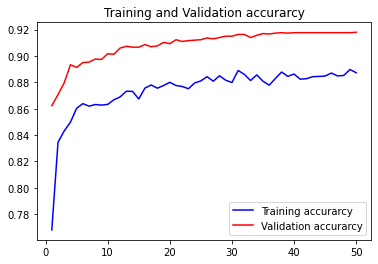

[INFO] Calculating model accuracy
94/94 [==============================] - 3s 28ms/step - loss: 0.0960 - accuracy: 0.9180
Test Accuracy: 91.79999828338623


In [13]:
Res_Plot_Test_Save('VGG19_Imagenet.h5')